In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import (train_test_split, GridSearchCV, LeaveOneOut, KFold,
                                     cross_val_score)

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [2]:
# read offense data
offense = pd.read_csv('data/offense.csv')
# read defense data
defense = pd.read_csv('data/defense.csv')
# read salary data
salary = pd.read_csv('data/salary.csv', index_col=0)
# change columns (uppercase first letter) to match the other data
salary.columns = ['Team', 'Year'] + list(salary.columns[2:])
# read standings data
standings = pd.read_csv('data/standings.csv')

Need to fix the offense and defense stats so that they are the previous year. Can do this by adding 1 to the year before merging the datasets. Salary is known at the beginning of the season so the year doesn't have to change.

In [3]:
offense['Year'] += 1
defense['Year'] += 1

In [4]:
# merge the offense and defense data with suffixes
combined = pd.merge(offense, defense, on=['Team', 'Year'], suffixes=('_off', '_def'))
# merge the salary data
combined = pd.merge(combined, salary, on=['Team', 'Year'])
# merge the standings dataframe - use left so 2018 data stays
combined = pd.merge(combined, standings, on=['Team', 'Year'], how='left')

In [5]:
# split out the X and y from combined
X_all = combined[combined.columns[:-8]].copy()
y_all = combined[combined.columns[-8:]].copy()

# add team and year back into y
y_all.insert(0, 'Team', X_all['Team'])
y_all.insert(1, 'Year', X_all['Year'])

# add win percentage column
y_all['W_Pct'] = y_all['W'] / 16

In [6]:
# scale X
scaler = StandardScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X_all[X_all.columns[2:]]),
                        index=X_all.index, columns=X_all.columns[2:])

X_scaled.insert(0, 'Team', X_all['Team'])
X_scaled.insert(1, 'Year', X_all['Year'])

In [7]:
# break out the 2018 data first (X_future)
X_future = X_scaled[X_scaled['Year'] == 2018]
y_future = y_all[y_all['Year'] == 2018]

# get the validation set (2017)
X_valid = X_scaled[X_scaled['Year'] == 2017].drop(['Team', 'Year'], axis=1)
y_valid = y_all[y_all['Year'] == 2017].drop(['Team', 'Year'], axis=1)

# remove the 2017 and 2018 data from X and y
X = X_scaled[X_scaled['Year'] < 2017]
y = y_all[y_all['Year'] < 2017]

# keep team and year just in case
team_year = X_scaled[['Team', 'Year']]

# drop the team and year columns for X and y
X = X.drop(['Team', 'Year'], axis=1)
y = y.drop(['Team', 'Year'], axis=1)

# Baseline Models

Predicting win percentage (W_Pct)

In [53]:
# split into train and test set

target_var = 'W_Pct'
rs = 0

def get_train_test():
    return train_test_split(X, y[target_var],
                            test_size=0.3, random_state=rs)

R2 Score: 0.005861250327653833
RMSE: 0.19644550199328642


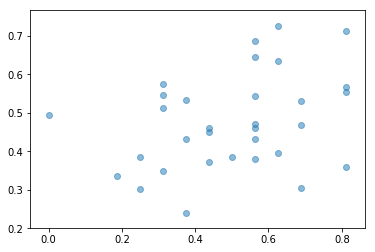

In [54]:
lr = LinearRegression()

lr.fit(X, y[target_var])

y_pred = lr.predict(X_valid)

print('R2 Score: {}'.format(r2_score(y_valid[target_var], y_pred)))
print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_valid[target_var], y_pred))))

_ = plt.scatter(y_valid[target_var], y_pred, alpha=0.5)

## Linear Regression with PCA 

In [56]:
from sklearn.decomposition import PCA

pca = PCA(random_state=rs)

X_pca = pd.DataFrame(pca.fit_transform(X), index=X.index)

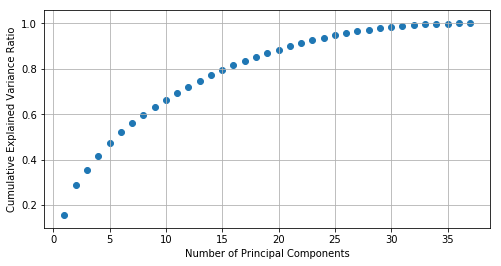

In [57]:
pca.explained_variance_ratio_.cumsum()

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

_ = ax.scatter(range(1, len(X_pca.columns)+1), pca.explained_variance_ratio_.cumsum())
_ = ax.set(xlabel='Number of Principal Components', ylabel='Cumulative Explained Variance Ratio')
_ = ax.grid()

In [58]:
lr = LinearRegression()
lr.fit(X_pca, y[target_var])
y_pred = lr.predict(pca.transform(X_valid))
r2_score(y_valid[target_var], y_pred)

0.0058612503276547212

Best 


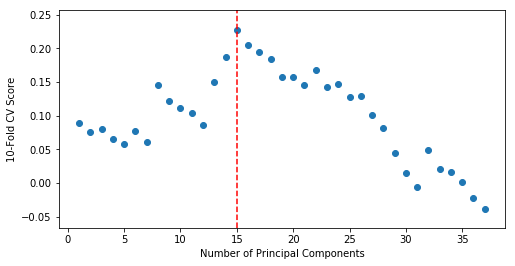

In [59]:
lr = LinearRegression()

cv_scores = []

for i in range(1, len(X.columns)+1):
    pca = PCA(n_components=i, random_state=rs)
    X_pca = pca.fit_transform(X)
    lr.fit(X_pca, y[target_var])
    cv_scores.append(cross_val_score(lr, X_pca, y[target_var], cv=10).mean())

cv_scores = np.array(cv_scores)
best_n = cv_scores.argmax() + 1
print('Best ')

fig, ax = plt.subplots(1, 1, figsize=(8, 4))    
    
_ = ax.scatter(range(1, len(X.columns)+1), cv_scores)
_ = ax.axvline(best_n, c='r', ls='--')
_ = ax.set(xlabel='Number of Principal Components', ylabel='10-Fold CV Score')

In [60]:
pca = PCA(n_components=best_n, random_state=rs)
X_pca = pca.fit_transform(X)
lr.fit(X_pca, y[target_var])
print('Training R2: {:.4f}'.format(lr.score(X_pca, y[target_var])))
print('Validation R2: {:.4f}'.format(lr.score(pca.transform(X_valid), y_valid[target_var])))

lr_pca_pred = lr.predict(pca.transform(X_valid))
lr_pca_model = lr

Training R2: 0.3955
Validation R2: 0.1376


## Forward Subset Selection with Leave One Out Cross Validation

In [15]:
fs_models = {}

unused_vars = X.columns
model_vars = []

lr = LinearRegression()

loo = LeaveOneOut()

mse = []

for i in range(1, len(X.columns) + 1):
    best_mse = 1e100
    for var in unused_vars:
        loo_mse = []
        for train_index, test_index in loo.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index][target_var], y.iloc[test_index][target_var]
            lr.fit(X_train[model_vars + [var]], y_train)
            y_pred = lr.predict(X_test[model_vars + [var]])
            loo_mse.append((y_test.values - y_pred) ** 2)
        if np.mean(loo_mse) < best_mse:
            best_mse = np.mean(loo_mse)
            best_var = var
    mse.append(best_mse)
    model_vars.append(best_var)
    unused_vars = unused_vars.drop(best_var)
    fs_models[i] = [best_mse, model_vars.copy()]

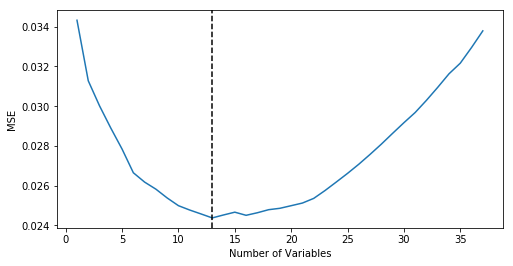

In [16]:
min_pt = min(fs_models, key=fs_models.get)
best_vars = fs_models[min_pt][1]

fig, ax1 = plt.subplots(1, 1, figsize=(8, 4))

_ = ax1.plot(range(1, len(X.columns)+1), mse)
_ = ax1.axvline(min_pt, c='k', linestyle='dashed')
_ = ax1.set(xlabel='Number of Variables', ylabel='MSE')

Training R2: 0.47432333263403276
Validation R2: 0.05556385259156249


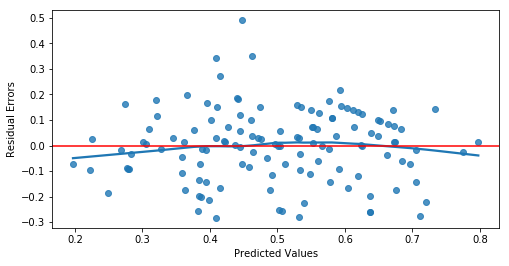

In [17]:
lr.fit(X[best_vars], y[target_var])
print('Training R2: {}'.format(lr.score(X[best_vars], y[target_var])))
print('Validation R2: {}'.format(lr.score(X_valid[best_vars], y_valid[target_var])))
y_pred = lr.predict(X[best_vars])
residuals = y[target_var] - y_pred

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

_ = sns.regplot(y_pred, residuals, lowess=True, ax=ax)
_ = ax.axhline(0, c='r')
_ = ax.set(xlabel='Predicted Values', ylabel='Residual Errors')

lr_pred = lr.predict(X_valid[best_vars])
lr_model = lr

## Lasso with 10-Fold Cross Validation

In [61]:
from sklearn.model_selection import LeaveOneOut

if target_var == 'W_Pct':
    alphas = np.linspace(.001, .1, 100)
elif target_var == 'DIFF':
    alphas = np.linspace(0.1, 100, 100)

lasso = Lasso()

kf = KFold(n_splits=10, random_state=rs)

mse = []
coefs = []
for a in alphas:
    lasso.set_params(alpha=a)
    kf_mse = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index][target_var], y.iloc[test_index][target_var]
        lasso.fit(X_train, y_train)
        y_pred = lasso.predict(X_test)
        kf_mse.append(np.mean((y_test.values - y_pred) ** 2))
    lasso.fit(X, y[target_var])
    coefs.append(lasso.coef_)
    mse.append(np.mean(kf_mse))
coefs = np.array(coefs)
mse = np.array(mse)

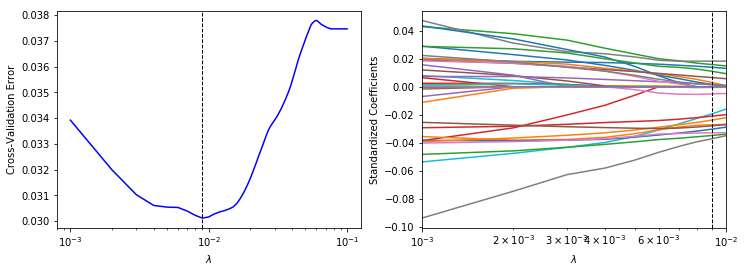

In [62]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.semilogx(alphas, mse, color='blue')
min_ind = mse.argmin()
ax1_ylim = ax1.get_ylim()
ax1.axvline(alphas[min_ind], linestyle='dashed', color='k', linewidth=1)
ax1.set(ylim=ax1_ylim, xlabel=r'$\lambda$', ylabel='Cross-Validation Error')

for i in range(len(X.columns)):
    ax2.semilogx(alphas, coefs[:, i], label=X.columns[i])
    
ax2.axvline(alphas[min_ind], linestyle='dashed', color='k', linewidth=1)
if target_var == 'W_Pct':
    xlim = (.001, .01)
elif target_var == 'DIFF':
    xlim = (1, 5)
_ = ax2.set(xlim=xlim, xlabel=r'$\lambda$', ylabel='Standardized Coefficients')

Training R2: 0.43574671734155224
validation R2: 0.2250462209808245


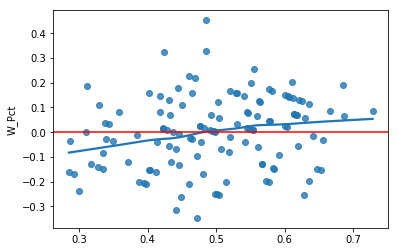

In [63]:
lasso.set_params(alpha=alphas[min_ind])
lasso.fit(X, y[target_var])
print('Training R2: {}'.format(lasso.score(X, y[target_var])))
print('validation R2: {}'.format(lasso.score(X_valid, y_valid[target_var])))
y_pred = lasso.predict(X)

residuals = y[target_var] - y_pred

sns.regplot(y_pred, residuals, lowess=True)
plt.axhline(0, c='r')

lasso_pred = lasso.predict(X_valid)
lasso_model = lasso

## Random Forest Regression with Grid Search

In [64]:
rf = RandomForestRegressor(n_estimators=100, random_state=rs)

param_grid = {
    'max_depth': range(1, 10),
    'min_samples_leaf': range(1, 4),
    'min_samples_split': range(2, 5)
}

gs = GridSearchCV(rf, param_grid, n_jobs=-1, cv=10)
gs.fit(X, y[target_var])

print(gs.best_score_, gs.best_params_)

0.0615293895727 {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}


Training R2: 0.6911399403023633
Validation R2: 0.17190022702694485


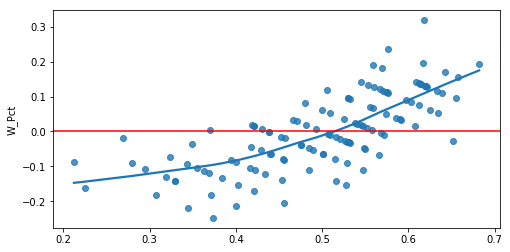

In [65]:
rf = gs.best_estimator_

print('Training R2: {}'.format(rf.score(X, y[target_var])))
print('Validation R2: {}'.format(rf.score(X_valid, y_valid[target_var])))

y_pred = rf.predict(X)

residuals = y[target_var] - y_pred

fig, ax = plt.subplots(1, 1, figsize=(8, 4))

_ = sns.regplot(y_pred, residuals, lowess=True, ax=ax)
_ = ax.axhline(0, c='r')

rf_pred = rf.predict(X_valid)

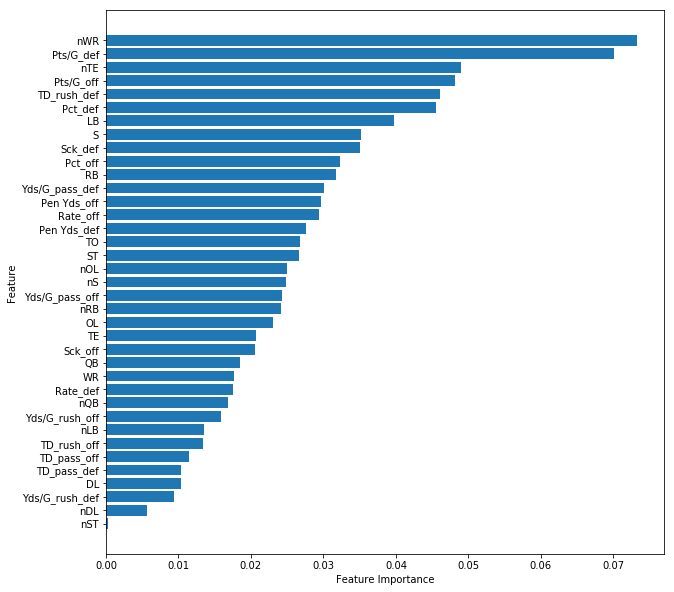

In [66]:
indices = np.argsort(rf.feature_importances_)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

_ = ax.barh(range(len(indices)), rf.feature_importances_[indices], align='center')
_ = plt.yticks(range(len(indices)), X.columns[indices])
_ = ax.set(xlabel='Feature Importance', ylabel='Feature')

## Blending Models

In [250]:
models = [lr_model, lr_pca_model, lasso_model, rf_model]

preds = pd.DataFrame([lr_pred, lr_pca_pred, lasso_pred, rf_pred]).T
preds.columns = ['lr', 'lr_pca', 'lasso', 'rf']

#### Average of Predictions

In [279]:
for col in preds.columns:
    print('{:^7} Validation R2: {:.4f}'.format(col, r2_score(y_valid[target_var], preds[col])))
print('Blended Validation R2: {:.4f}\n'.format(r2_score(y_valid[target_var], preds.mean(axis=1))))

for col in preds.columns:
    print('{:^7} Validation MSE: {:.4f}'.format(col, mean_squared_error(y_valid[target_var], preds[col])))
print('Blended Validation MSE: {:.4f}'.format(mean_squared_error(y_valid[target_var], preds.mean(axis=1))))

lr_pca  Validation R2: 0.1376
 lasso  Validation R2: 0.2250
  rf    Validation R2: 0.1719
Blended Validation R2: 0.2210

lr_pca  Validation MSE: 0.0335
 lasso  Validation MSE: 0.0301
  rf    Validation MSE: 0.0321
Blended Validation MSE: 0.0302


#### Linear Regression of Predictions

In [280]:
lr = LinearRegression()

lr.fit(preds, y_valid[target_var])

y_pred = lr.predict(preds)

print('Linear Regression Model Blend R2: {}'.format(r2_score(y_valid[target_var], y_pred)))
print('Linear Regression Model Blend MSE: {}'.format(mean_squared_error(y_valid[target_var], y_pred)))

Linear Regression Model Blend R2: 0.2727666380574316
Linear Regression Model Blend MSE: 0.028230005993376068


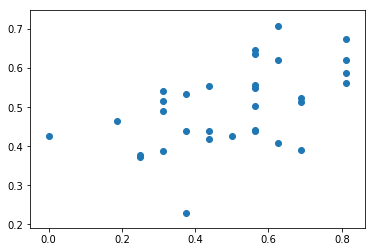

In [281]:
plt.scatter(y_valid[target_var], y_pred)

In [282]:
list(zip(team_year[team_year['Year'] == 2017]['Team'], 
         team_year[team_year['Year'] == 2017]['Year'],
         y_valid[target_var], y_pred))

[('BUF', 2017, 0.5625, 0.44134341303305513),
 ('DAL', 2017, 0.5625, 0.6458068376130881),
 ('TEN', 2017, 0.5625, 0.63694153566997769),
 ('SF', 2017, 0.375, 0.23010844298190297),
 ('ATL', 2017, 0.625, 0.62162096388271859),
 ('OAK', 2017, 0.375, 0.53500165965186364),
 ('NE', 2017, 0.8125, 0.67587406299575115),
 ('HOU', 2017, 0.25, 0.37190498312597731),
 ('MIA', 2017, 0.375, 0.4386711358335702),
 ('CAR', 2017, 0.6875, 0.51374213862554152),
 ('PHI', 2017, 0.8125, 0.58642317408614186),
 ('NYJ', 2017, 0.3125, 0.38648147895319607),
 ('CIN', 2017, 0.4375, 0.43909477725633517),
 ('PIT', 2017, 0.8125, 0.62129056495436741),
 ('KC', 2017, 0.625, 0.70893559286688768),
 ('NO', 2017, 0.6875, 0.39089573371837305),
 ('CHI', 2017, 0.3125, 0.54136073660205042),
 ('ARI', 2017, 0.5, 0.42530208825950122),
 ('CLE', 2017, 0.0, 0.4257946477633211),
 ('GB', 2017, 0.4375, 0.55342203987181238),
 ('WAS', 2017, 0.4375, 0.41916507982066087),
 ('JAC', 2017, 0.625, 0.4094629795616902),
 ('IND', 2017, 0.25, 0.3775113643

## 2017 Playoff Predictions 

In [283]:
divisions = {
    'afc_east': ['NE', 'BUF', 'MIA', 'NYJ'],
    'afc_north': ['PIT', 'BAL', 'CIN', 'CLE'],
    'afc_south': ['JAC', 'TEN', 'IND', 'HOU'],
    'afc_west': ['KC', 'LAC', 'OAK', 'DEN'],
    'nfc_east': ['PHI', 'DAL', 'WAS', 'NYG'],
    'nfc_north': ['MIN', 'DET', 'GB', 'CHI'],
    'nfc_south': ['NO', 'CAR', 'ATL', 'TB'],
    'nfc_west': ['LA', 'SEA', 'ARI', 'SF']
}

In [285]:
pred_df = team_year[team_year['Year'] == 2017].copy()
pred_df['actual'] = y_valid[target_var]
pred_df['predicted'] = y_pred

In [286]:
for key in divisions.keys():
    print(key)
    tmp = pred_df[pred_df['Team'].isin(divisions[key])].copy()
    tmp['actual_rank'] = tmp['actual'].rank(ascending=False).astype(int)
    tmp['predicted_rank'] = tmp['predicted'].rank(ascending=False).astype(int)
    display(tmp.sort_values('actual_rank'))

afc_east


,Team,Year,actual,predicted,actual_rank,predicted_rank
134,NE,2017,0.8125,0.675874,1,1
128,BUF,2017,0.5625,0.441343,2,2
136,MIA,2017,0.3750,0.438671,3,3
139,NYJ,2017,0.3125,0.386481,4,4


afc_north


,Team,Year,actual,predicted,actual_rank,predicted_rank
141,PIT,2017,0.8125,0.621291,1,1
155,BAL,2017,0.5625,0.502703,2,2
140,CIN,2017,0.4375,0.439095,3,3
146,CLE,2017,0.0000,0.425795,4,4


afc_south


,Team,Year,actual,predicted,actual_rank,predicted_rank
149,JAC,2017,0.6250,0.409463,1,2
130,TEN,2017,0.5625,0.636942,2,1
135,HOU,2017,0.2500,0.371905,3,4
150,IND,2017,0.2500,0.377511,3,3


afc_west


,Team,Year,actual,predicted,actual_rank,predicted_rank
142,KC,2017,0.6250,0.708936,1,1
153,LAC,2017,0.5625,0.439042,2,4
133,OAK,2017,0.3750,0.535002,3,2
154,DEN,2017,0.3125,0.489658,4,3


nfc_east


,Team,Year,actual,predicted,actual_rank,predicted_rank
138,PHI,2017,0.8125,0.586423,1,2
129,DAL,2017,0.5625,0.645807,2,1
148,WAS,2017,0.4375,0.419165,3,4
156,NYG,2017,0.1875,0.464586,4,3


nfc_north


,Team,Year,actual,predicted,actual_rank,predicted_rank
159,MIN,2017,0.8125,0.561859,1,1
157,DET,2017,0.5625,0.557731,2,2
147,GB,2017,0.4375,0.553422,3,3
144,CHI,2017,0.3125,0.541361,4,4


nfc_south


,Team,Year,actual,predicted,actual_rank,predicted_rank
137,CAR,2017,0.6875,0.513742,1,3
143,NO,2017,0.6875,0.390896,1,4
132,ATL,2017,0.6250,0.621621,3,1
151,TB,2017,0.3125,0.514965,4,2


nfc_west


,Team,Year,actual,predicted,actual_rank,predicted_rank
158,LA,2017,0.6875,0.523386,1,2
152,SEA,2017,0.5625,0.549915,2,1
145,ARI,2017,0.5000,0.425302,3,3
131,SF,2017,0.3750,0.230108,4,4


## Best Model Discussion

For the prediction of win percentage I built 4 models:
* lr
 * Linear regression
 * Forward selection (13 features)
 * Leave one out cross validation
* lr_pca
 * Linear regression
 * Using PCA (15 principal components)
 * 10-fold cross validation
* lasso
 * Lasso regression
 * 10-fold cross validation
* rf
 * Random forest
 * 10-fold cross validation
 * Grid search
 
I also used linear regression to blend the predictions of each model.

The best model was the lasso regression model which correctly predicted 7 of 8 division winners and 8 of 12 playoff teams (including wild card teams).

## Predict 2018 with the Lasso Model

In [314]:
X_future_scaled = pd.DataFrame(scaler.fit_transform(X_future[X_future.columns[2:]]), 
                               index=X_future.index, 
                               columns=X_future.columns[2:])

y_pred = lasso_model.predict(X_future_scaled)

In [317]:
future_teams = X_future[['Team', 'Year']].copy()
future_teams['prediction'] = y_pred

In [318]:
future_teams

,Team,Year,prediction
160,JAC,2018,0.587623
161,DAL,2018,0.656343
162,PHI,2018,0.570293
163,CAR,2018,0.538363
164,NO,2018,0.457075
165,BUF,2018,0.304025
166,MIN,2018,0.651475
167,LA,2018,0.556465
168,KC,2018,0.417760
169,NE,2018,0.576019


In [327]:
for key in divisions.keys():
    print('\n---{}---'.format(key.upper()))
    tmp = future_teams[future_teams['Team'].isin(divisions[key])].copy()
    tmp['prediction_rank'] = tmp['prediction'].rank(ascending=False).astype(int)
    display(tmp.sort_values('prediction_rank'))


---AFC_EAST---


,Team,Year,prediction,prediction_rank
169,NE,2018,0.576019,1
188,MIA,2018,0.364997,2
165,BUF,2018,0.304025,3
178,NYJ,2018,0.206075,4



---AFC_NORTH---


,Team,Year,prediction,prediction_rank
179,PIT,2018,0.595822,1
170,BAL,2018,0.583935,2
177,CLE,2018,0.458391,3
190,CIN,2018,0.412840,4



---AFC_SOUTH---


,Team,Year,prediction,prediction_rank
160,JAC,2018,0.587623,1
174,TEN,2018,0.584466,2
173,HOU,2018,0.331689,3
181,IND,2018,0.167898,4



---AFC_WEST---


,Team,Year,prediction,prediction_rank
183,LAC,2018,0.701378,1
171,DEN,2018,0.537753,2
168,KC,2018,0.417760,3
184,OAK,2018,0.405881,4



---NFC_EAST---


,Team,Year,prediction,prediction_rank
161,DAL,2018,0.656343,1
162,PHI,2018,0.570293,2
187,WAS,2018,0.382945,3
185,NYG,2018,0.367906,4



---NFC_NORTH---


,Team,Year,prediction,prediction_rank
166,MIN,2018,0.651475,1
176,GB,2018,0.470076,2
175,CHI,2018,0.458482,3
191,DET,2018,0.427859,4



---NFC_SOUTH---


,Team,Year,prediction,prediction_rank
172,ATL,2018,0.604707,1
163,CAR,2018,0.538363,2
186,TB,2018,0.475874,3
164,NO,2018,0.457075,4



---NFC_WEST---


,Team,Year,prediction,prediction_rank
182,SEA,2018,0.558484,1
167,LA,2018,0.556465,2
180,SF,2018,0.496589,3
189,ARI,2018,0.489484,4
